# 0 Utils

## 0.1 Imports and paths

In [1]:
import glob
import pympi
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_folder = f'/home/janko/Desktop/social-dining/data'

annotations_folder = f'{data_folder}/annotation/annotation-files'
videos_folder = f'{data_folder}/raw/video'

person_speaking_features_folder = f'{data_folder}/processed/audio-features/person-speaking'

pre_study_questionnaire_file = f'{data_folder}/questionnaires/Pre-StudyQuestionnaire.csv'
post_study_questionnaire_file = f'{data_folder}/questionnaires/Post-StudyQuestionnaire.csv'


## 0.2 Load questionnaire data

In [2]:
# Note: first two rows contain headers => use [2:]
pre_df = pd.read_csv(pre_study_questionnaire_file)[2:].reset_index(drop=True)
post_df = pd.read_csv(post_study_questionnaire_file)[2:].reset_index(drop=True)

# Sort by video id ({session_id}_{participant_position})
pre_df  = pre_df.sort_values(by=['I2', 'I3']).reset_index(drop=True)
post_df = post_df.sort_values(by=['I1', 'I2']).reset_index(drop=True)


In [14]:
# Iterate over sessions and calculate speaking and dining activities per participant
# Note: session 09 had no audio recorded and so the speaking activity is set to np.nan
for session_id in [f'{i + 1:02d}' for i in range(30)]:
    # Take a unifying minimum video frame count for this session
    num_frames = np.array([ cv2.VideoCapture(f'{videos_folder}/{session_id}_{participant_position}.mp4').get(cv2.CAP_PROP_FRAME_COUNT) for participant_position in [1, 2, 3] ])
    # print(max(num_frames - min(num_frames)))
    if session_id != '09':
        person_speaking_features = np.load(f'{person_speaking_features_folder}/{session_id}.npy')
        # num_frames = np.array(num_frames.tolist() + [len(person_speaking_features)])
        # print(max(num_frames - min(num_frames)))
        print(min(num_frames) - len(person_speaking_features))


0.0
-8.0
-10.0
-9.0
-9.0
-13.0
-10.0
3.0
-1.0
-12.0
-11.0
5.0
-8.0
-12.0
-13.0
-19.0
2.0
-17.0
-7.0
0.0
-3.0
-18.0
15.0
-9.0
-5.0
-10.0
-2.0
3.0
-11.0


# 1 Social activity

We quantify social activity in terms of
- **Speaking activity** = fraction of recording time the participant was speaking (computed only for 29 x 3 participants as the audio was not recorded for session 09)
- **Dining activity** = frequency of eating/drinking/using a napkin (i.e., total number of food_to_mouth, drink_to_mouth, and napkin_to_mouth annotations normalized by recording time)


In [3]:
tier_names = [
    'food_to_mouth',
    'drink_to_mouth',
    'napkin_to_mouth'
]
# Frame rate of audio and video features
FPS = 30.
speaking_activity = []
dining_activity = []

# Iterate over sessions and calculate speaking and dining activities per participant
# Note: session 09 had no audio recorded and so the speaking activity is set to np.nan
for session_id in [f'{i + 1:02d}' for i in range(30)]:
    # Take a unifying minimum video frame count for this session
    num_frames = int(min(
        [ cv2.VideoCapture(f'{videos_folder}/{session_id}_{participant_position}.mp4').get(cv2.CAP_PROP_FRAME_COUNT) for participant_position in [1, 2, 3] ] 
    ))

    if session_id == '09':
        print(f'Speaking activity for session 09 is np.nan as there was no audio recorded.')
    else:
        person_speaking_features = np.load(f'{person_speaking_features_folder}/{session_id}.npy')
        assert set(person_speaking_features).issubset({0, 1, 2, 3}), f'Invalid speaking features found in session {session_id}'

        # Take a unifying minimum frame count for this session, including the audio frame count
        num_frames = min(num_frames, len(person_speaking_features))
        person_speaking_features = person_speaking_features[:num_frames]

    for participant_position in [1, 2, 3]:
        # Speaking activity (% of time speaking)
        if session_id == '09':
            speaking_activity.append(np.nan)
        else:
            current_participant_speaking = (person_speaking_features == participant_position).astype(int)
            if np.sum(current_participant_speaking) == len(person_speaking_features):
                print(f'{session_id}_{participant_position}: always talking')
            if np.sum(current_participant_speaking) == 0:
                print(f'{session_id}_{participant_position}: never talking')
            speaking_activity.append( 100 * np.sum(current_participant_speaking) / len(person_speaking_features) )

        # Dining activity (# annotations / min)
        eaf_obj1 = pympi.Elan.Eaf(f'{annotations_folder}/{session_id}_{participant_position}.eaf')
        num_annotations = 0
        for tier_name in tier_names:
            for annotation_start_time, _, _ in eaf_obj1.get_annotation_data_for_tier(tier_name):
                if (annotation_start_time / 1000.) <= (num_frames / FPS):
                    num_annotations += 1
                else:
                    print(f'Annotation outside of the maximum unifying frame count')
        duration = (num_frames / FPS) / 60
        dining_activity.append( num_annotations / duration )

speaking_activity = np.array(speaking_activity)
dining_activity = np.array(dining_activity)


Speaking activity for session 09 is np.nan as there was no audio recorded.


## 1.1 Relationship between Speaking activity and Dining activity

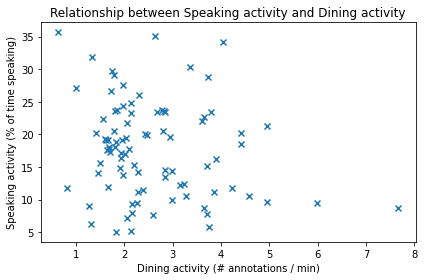

In [4]:
plt.figure()
plt.scatter(dining_activity, speaking_activity, marker='x')
plt.xlabel(f'Dining activity (# annotations / min)')
plt.ylabel(f'Speaking activity (% of time speaking)')
plt.title("Relationship between Speaking activity and Dining activity")
plt.tight_layout()
plt.show()


## 1.2 Relationship between social activity and questionnaire data

### 1.2.0 Plotting functions

In [5]:
def plot_scatter(data, categories, categories_label, fig_size=(6.4, 4.8)):
    plt.figure(figsize=fig_size)
    for category in categories:
        idx = np.where(data == category)[0]
        # Remove speaking activity data from session 09 that were set to np.nan
        idx_to_remove = np.argwhere(np.isnan(speaking_activity))[:, 0]
        idx = np.array([ ii for ii in idx if ii not in idx_to_remove ], dtype=int)
        plt.scatter(dining_activity[idx], speaking_activity[idx], marker='o', label=category)
    plt.xlabel(f'Dining activity (# annotations / min)')
    plt.ylabel(f'Speaking activity (% of time speaking)')
    plt.title(f"Social activity in terms of participants' {categories_label[0].lower() + categories_label[1:]}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_boxplot(data, categories, categories_label, relationships=False, fig_size=(8, 4)):
    plt.figure(figsize=fig_size)
    for i, activity in enumerate(['dining', 'speaking']):
        boxes = []
        for category in categories:
            if relationships:
                # When plotting participants' relationship data, 
                # there are 2 relationships and so 2 datapoints for each participant
                idx_left = np.where(data['left'] == category)[0]
                idx_right = np.where(data['right'] == category)[0]
                idx = np.concatenate((idx_left, idx_right))
            else:
                idx = np.where(data == category)[0]
            if activity == 'dining':
                boxes.append(dining_activity[idx])
            elif activity == 'speaking':
                # Remove speaking activity data from session 09 that were set to np.nan
                idx_to_remove = np.argwhere(np.isnan(speaking_activity))[:, 0]
                idx = np.array([ ii for ii in idx if ii not in idx_to_remove ], dtype=int)
                boxes.append(speaking_activity[idx])

        c = 'blue'
        x_positions = np.arange(0, len(categories))
        plt.subplot(1, 2, i + 1)
        plt.boxplot(boxes,
            positions=x_positions,
            # widths=bin_width,
            # meanline=True, 
            showmeans=True,
            notch=True,
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            # meanprops=dict(marker='+')
        )
        rotation = 90 if type(category) == str and len(list(categories)[0]) > 17 else 0
        plt.xticks(x_positions, categories, rotation=rotation)
        plt.xlabel(categories_label)
        if activity == 'dining':
            plt.ylabel(f'Dining activity (# annotations / min)')
        elif activity == 'speaking':
            plt.ylabel(f'Speaking activity (% of time speaking)')
    plt.suptitle(f"Social activity in terms of participants' {categories_label[0].lower() + categories_label[1:]}")
    plt.tight_layout()
    plt.show()


def plot_hist(data, categories, categories_label, relationships=False, fig_size=(8, 4)):
    plt.figure(figsize=fig_size)
    for i, activity in enumerate(['dining', 'speaking']):
        if activity == 'dining':
            bin_width = 0.5 # in # annotations per min
            unit = fr'(min$^{{-1}}$)'
        elif activity == 'speaking':
            bin_width = 2 # in %
            unit = fr'%'
        print(fr'Bin width: {bin_width} {unit}')

        plt.subplot(1, 2, i + 1)
        for category in categories:
            if relationships:
                # When plotting participants' relationship data, 
                # there are 2 relationships and so 2 datapoints for each participant
                idx_left = np.where(data['left'] == category)[0]
                idx_right = np.where(data['right'] == category)[0]
                idx = np.concatenate((idx_left, idx_right))
            else:
                idx = np.where(data == category)[0]
            if activity == 'dining':
                activity_data = dining_activity[idx]
            elif activity == 'speaking':
                # Remove speaking activity data from session 09 that were set to np.nan
                idx_to_remove = np.argwhere(np.isnan(speaking_activity))[:, 0]
                idx = np.array([ ii for ii in idx if ii not in idx_to_remove ], dtype=int)
                activity_data = speaking_activity[idx]
            if len(activity_data) == 0:
                print(f'\t No data for category {category}')
            else:
                bins_range = np.arange(min(activity_data, default=0), max(activity_data, default=0) + bin_width, bin_width)
                plt.hist(activity_data, alpha=0.35, bins=bins_range, 
                        label=fr'{category} : $\mu$ = {np.mean(activity_data):.1f} $\pm$ {np.std(activity_data):.1f} {unit}'
                )
        plt.legend()
        if activity == 'dining':
            plt.xlabel(f'Dining activity (# annotations / min)')
        elif activity == 'speaking':
            plt.xlabel(f'Speaking activity (% of time speaking)')
        if relationships:
            plt.ylabel('# relationships')
        else:
            plt.ylabel('# participants')
    plt.suptitle(f"Social activity in terms of participants' {categories_label[0].lower() + categories_label[1:]}")
    plt.tight_layout()
    plt.show()


### 1.2.1 Meal time

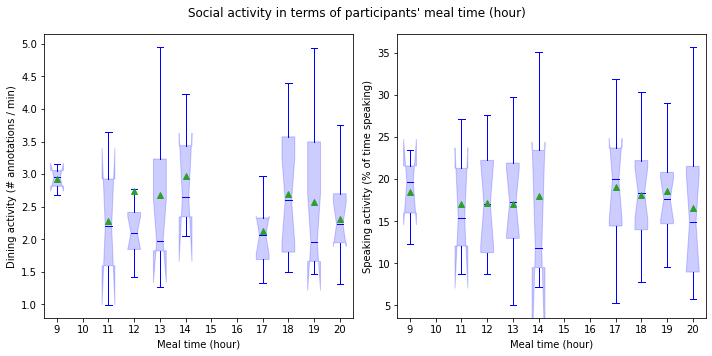

In [6]:
# Shift by two hours because the times (when the pre-study questionnaire was filled in) were automatically collected in the MDT time zone
meal_times = [ t.hour + 2 + (1 if t.minute > 30 else 0) for t in pd.to_datetime(pre_df['EndDate']) ]
# Group by sessions
# meal_times = meal_times[::3]

kwargs = dict(
    data = meal_times,
    categories = np.arange(min(meal_times), max(meal_times) + 1, 1),
    categories_label = 'Meal time (hour)',
    fig_size = (10, 5)
)
plot_boxplot(**kwargs)


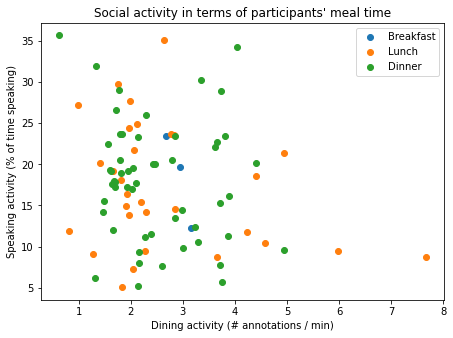

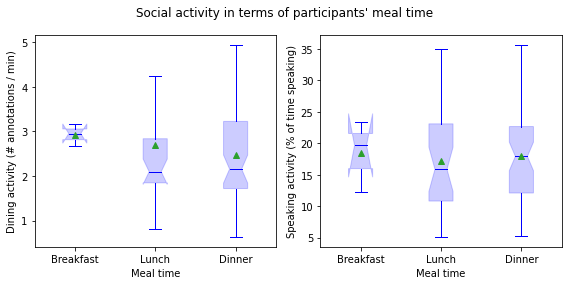

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


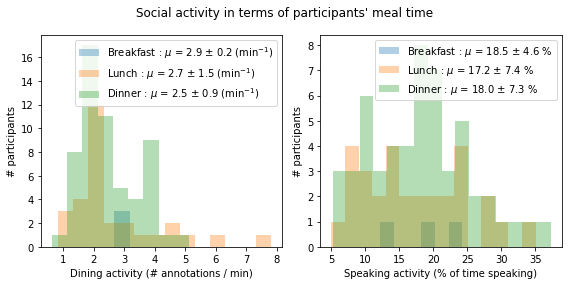

In [7]:
# Categorize into breakfast, lunch, and dinner times
meal_times_categories = ['Breakfast', 'Lunch', 'Dinner']
categorized_meal_times = []
for t in meal_times:
    if t < 10.5: categorized_meal_times.append('Breakfast')
    elif t < 16: categorized_meal_times.append('Lunch')
    else:        categorized_meal_times.append('Dinner')
kwargs = dict(
    data = np.array(categorized_meal_times),
    categories = meal_times_categories,
    categories_label = 'Meal time'
)
plot_scatter(**kwargs)
plot_boxplot(**kwargs)
plot_hist(**kwargs)


### 1.2.2 Demographics

#### 1.2.2.1 Age

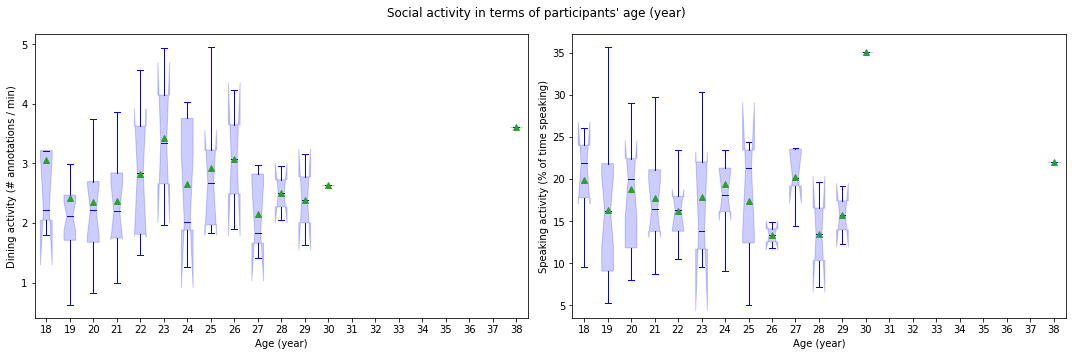

In [8]:
age = pd.to_numeric(pre_df['D1'])
kwargs = dict(
    data = age,
    categories = np.arange(min(age), max(age) + 1, 1),
    categories_label = 'Age (year)',
    fig_size = (15, 5)
)
plot_boxplot(**kwargs)


#### 1.2.2.2 Gender

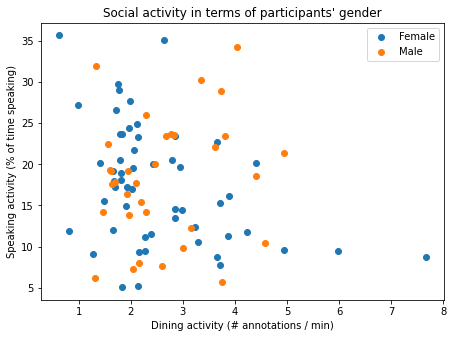

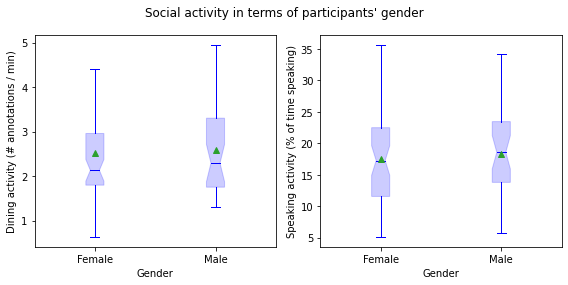

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


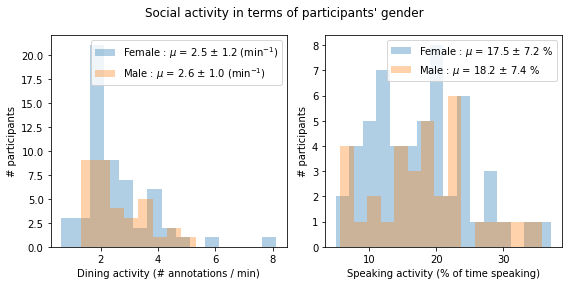

In [9]:
kwargs = dict(
    data = pre_df['D2'],
    categories = ['Female', 'Male'],
    categories_label = 'Gender'
)
plot_scatter(**kwargs)
plot_boxplot(**kwargs)
plot_hist(**kwargs)


#### 1.2.2.3 Race

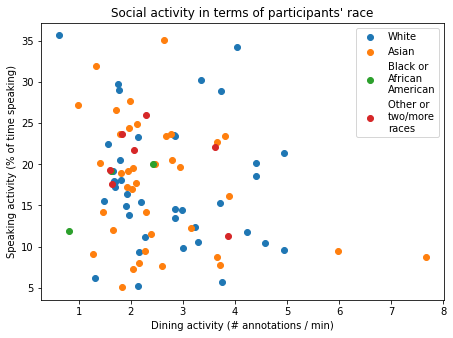

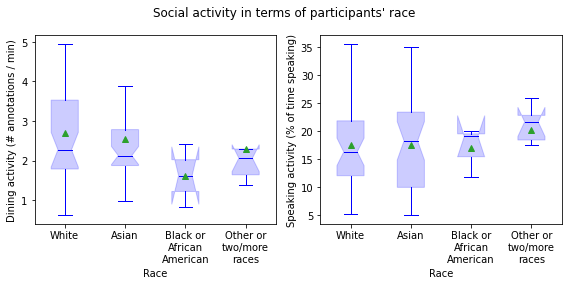

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


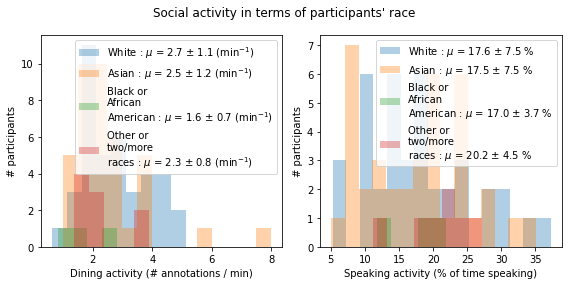

In [10]:
races_labels = {
    'White': 'White',
    'Asian': 'Asian',
    'Black or African American': 'Black or\nAfrican\nAmerican',
    'Other or two/more races': 'Other or\ntwo/more\nraces'
}
kwargs = dict(
    data = np.array([ races_labels[race] for race in pre_df['D3'] ]),
    categories = races_labels.values(),
    categories_label = 'Race'
)
plot_scatter(**kwargs)
plot_boxplot(**kwargs)
plot_hist(**kwargs)


#### 1.2.2.4 Handedness

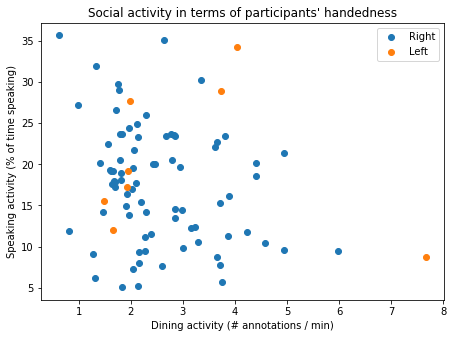

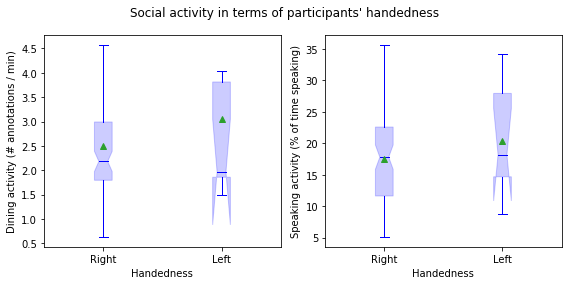

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


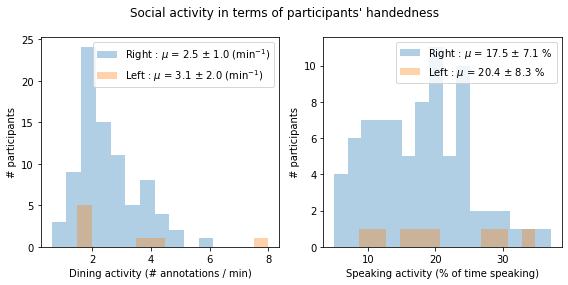

In [11]:
kwargs = dict(
    data = pre_df['D4'],
    categories = ['Right', 'Left'],
    categories_label = 'Handedness'
)
plot_scatter(**kwargs)
plot_boxplot(**kwargs)
plot_hist(**kwargs)


### 1.2.3 Participants' relationships

#### 1.2.3.1 Relationship type

In scatter plot, there would be always two datapoints at the same location, corresponsing to the participant's relationship to the co-diner on the left and on the right


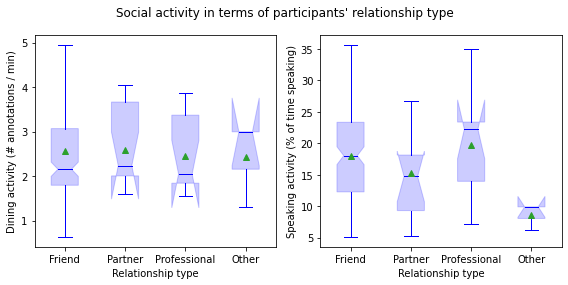

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


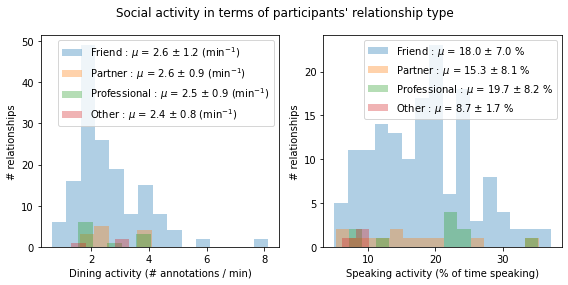

In [12]:
relationship_type_labels = {
    'Friend': 'Friend',
    'Partner': 'Partner',
    'Professional (co-worker/classmate)': 'Professional',
    'Other, please specify': 'Other'
}
kwargs = dict(
    data = dict(
        left = np.array([ relationship_type_labels[label] for label in pre_df['L1'] ]),
        right = np.array([ relationship_type_labels[label] for label in pre_df['R1'] ])
    ),
    categories = relationship_type_labels.values(),
    categories_label = 'Relationship type',
    relationships=True
)
print(f"In scatter plot, there would be always two datapoints at the same location, corresponsing to the participant's relationship to the co-diner on the left and on the right")
plot_boxplot(**kwargs)
plot_hist(**kwargs)


#### 1.2.3.2 Relationship duration

In scatter plot, there would be always two datapoints at the same location, corresponsing to the participant's relationship to the co-diner on the left and on the right


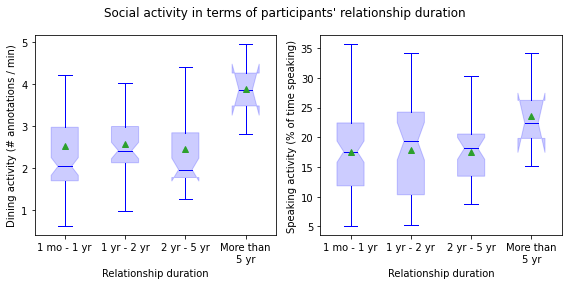

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


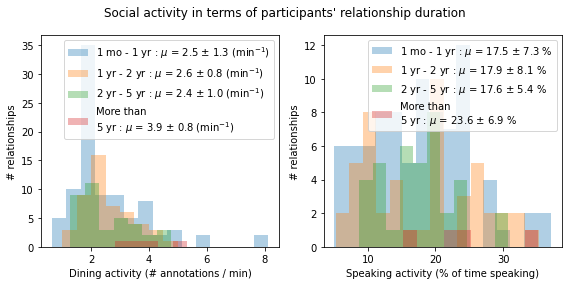

In [13]:
relationship_duration_labels = {
	'1 month - 1 year': '1 mo - 1 yr',
	'1 year - 2 years': '1 yr - 2 yr',
	'2 years - 5 years': '2 yr - 5 yr',
	'More than 5 years': 'More than\n5 yr'
}
kwargs = dict(
    data = dict(
        left = np.array([ relationship_duration_labels[label] for label in pre_df['L2'] ]),
        right = np.array([ relationship_duration_labels[label] for label in pre_df['R2'] ])
    ),
    categories = relationship_duration_labels.values(),
    categories_label = 'Relationship duration',
    relationships=True
)
print(f"In scatter plot, there would be always two datapoints at the same location, corresponsing to the participant's relationship to the co-diner on the left and on the right")
plot_boxplot(**kwargs)
plot_hist(**kwargs)


#### 1.2.3.3 Frequency of eating together

In scatter plot, there would be always two datapoints at the same location, corresponsing to the participant's relationship to the co-diner on the left and on the right


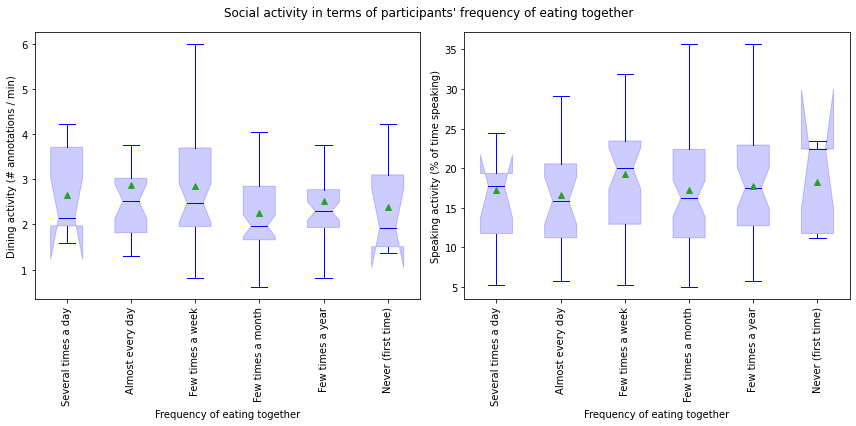

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


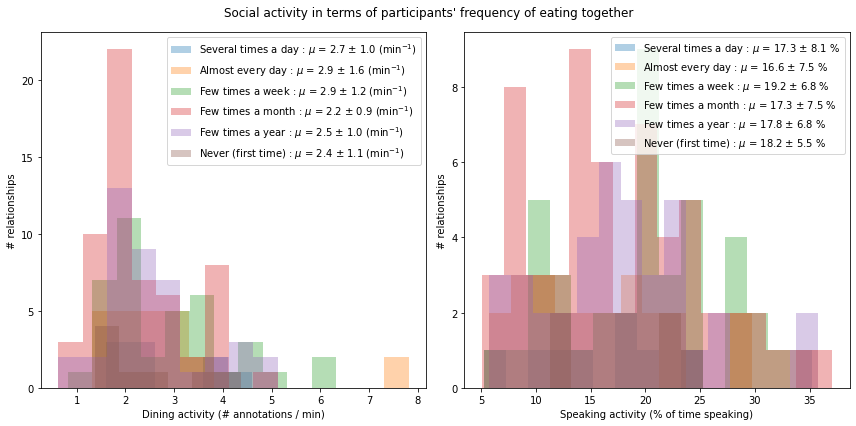

In [14]:
eating_together_freq_labels = {
    'Several times a day': 'Several times a day',
    'Almost every day': 'Almost every day',
    'Few times a week': 'Few times a week',
    'Few times a month': 'Few times a month',
    'Few times a year': 'Few times a year',
    'Never (this is the first time we are eating together)': 'Never (first time)'
}
kwargs = dict(
    data = dict(
        left = np.array([ eating_together_freq_labels[label] for label in pre_df['L3'] ]),
        right = np.array([ eating_together_freq_labels[label] for label in pre_df['R3'] ])
    ),
    categories = eating_together_freq_labels.values(),
    categories_label = 'Frequency of eating together',
    relationships=True,
    fig_size=(12, 6)
)
print(f"In scatter plot, there would be always two datapoints at the same location, corresponsing to the participant's relationship to the co-diner on the left and on the right")
plot_boxplot(**kwargs)
plot_hist(**kwargs)


### 1.2.4 Social dining habits

#### 1.2.4.1 Typical co-diner type

Breakfast


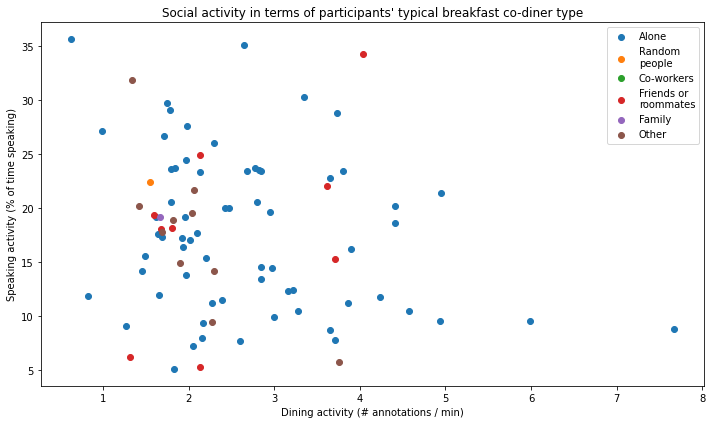

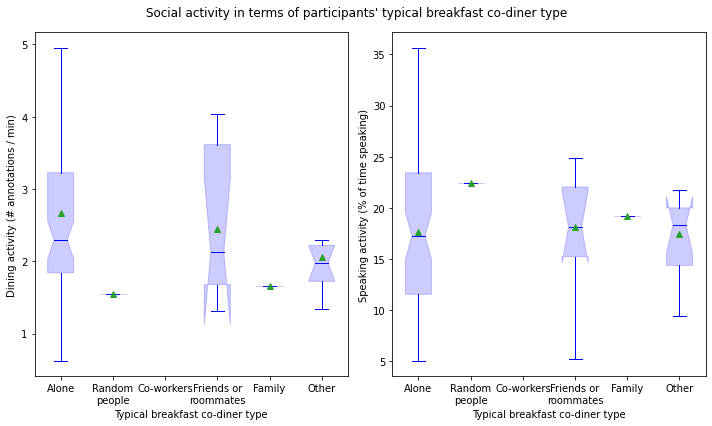

Bin width: 0.5 (min$^{-1}$)
	 No data for category Co-workers
Bin width: 2 %
	 No data for category Co-workers


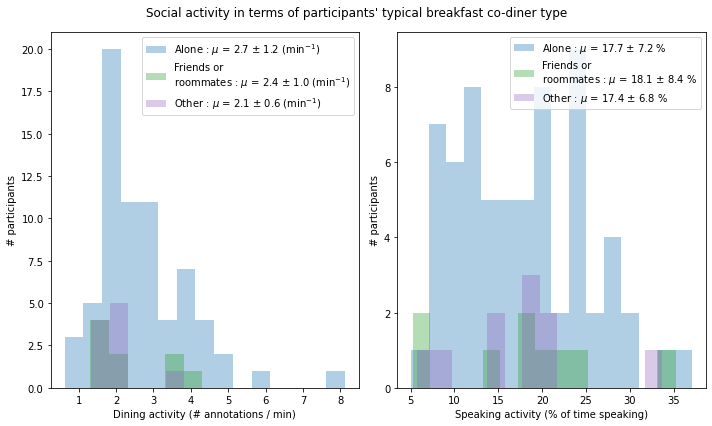

Lunch


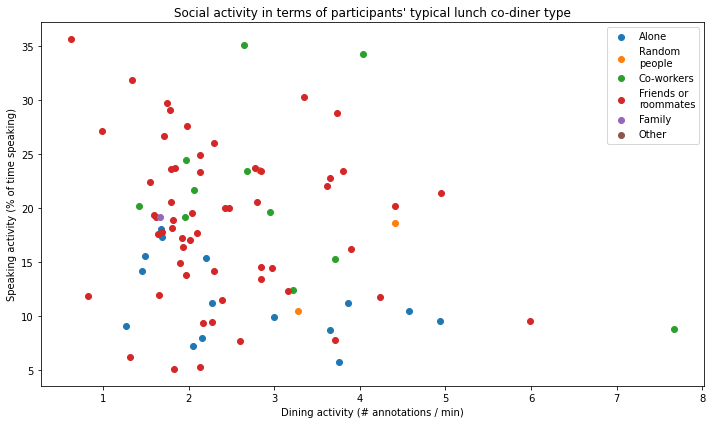

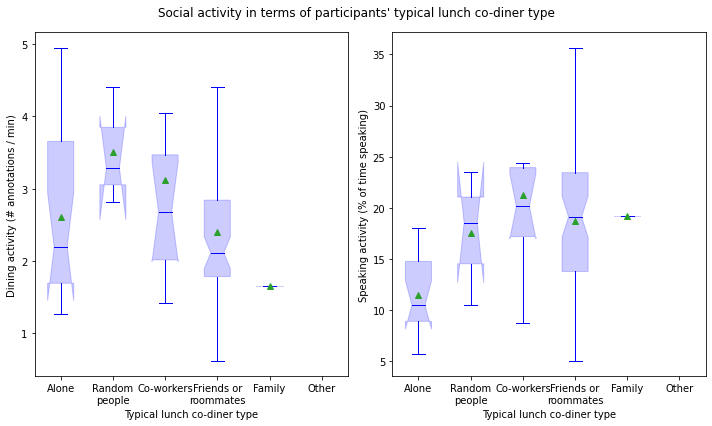

Bin width: 0.5 (min$^{-1}$)
	 No data for category Other
Bin width: 2 %
	 No data for category Other


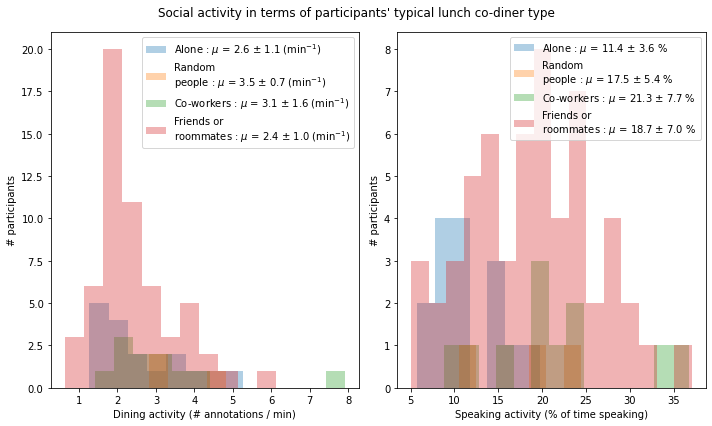

Dinner


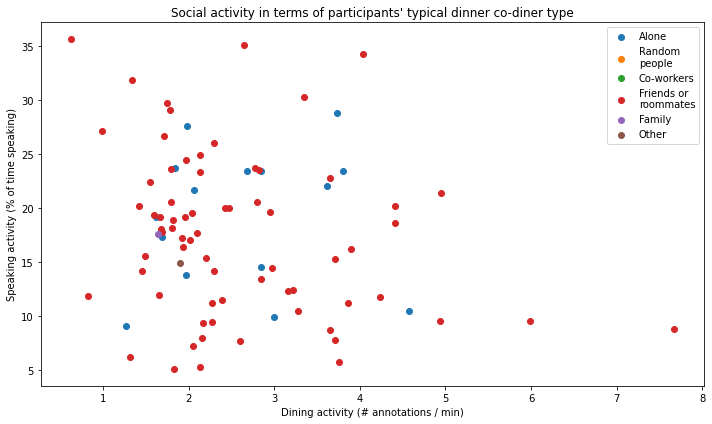

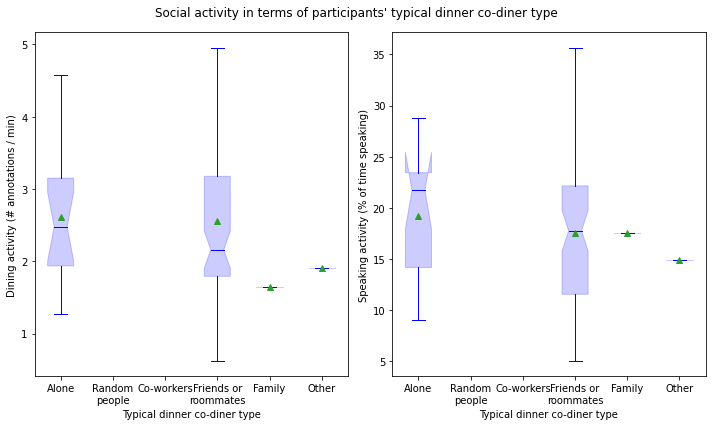

Bin width: 0.5 (min$^{-1}$)
	 No data for category Random
people
	 No data for category Co-workers
Bin width: 2 %
	 No data for category Random
people
	 No data for category Co-workers


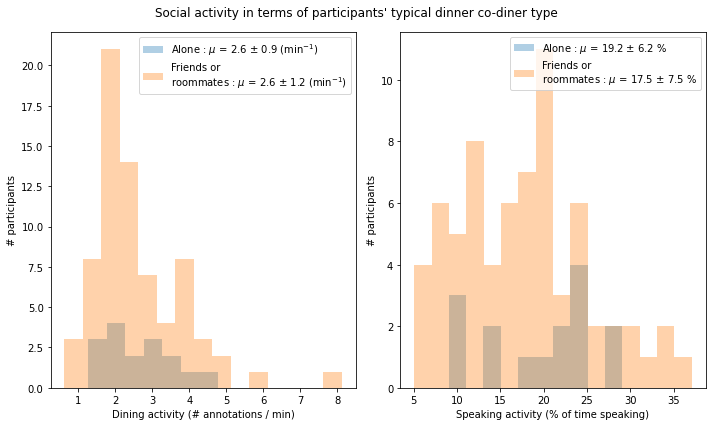

In [15]:
codiner_type_labels = {
    'Alone': 'Alone', 
    'Random people': 'Random\npeople', 
    'Co-workers': 'Co-workers', 
    'Friends/roommates': 'Friends or\nroommates', 
    'Family': 'Family', 
    'Other, please specify': 'Other'
}
for i, meal_type in enumerate(['Breakfast', 'Lunch', 'Dinner']):
    print(meal_type)
    kwargs = dict(
        data = np.array([ codiner_type_labels[label] for label in pre_df[f'S1_{i + 1}'] ]),
        categories = codiner_type_labels.values(),
        categories_label = f'Typical {meal_type.lower()} co-diner type',
        fig_size=(10, 6)
    )
    plot_scatter(**kwargs)
    plot_boxplot(**kwargs)
    plot_hist(**kwargs)


#### 1.2.4.2 Typical social dining frequency

Breakfast


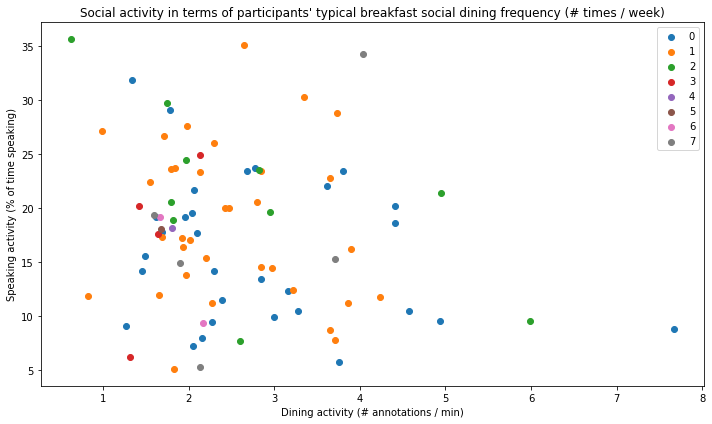

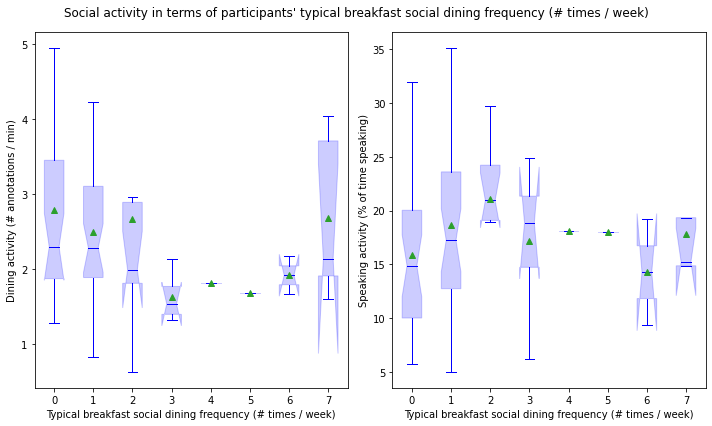

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


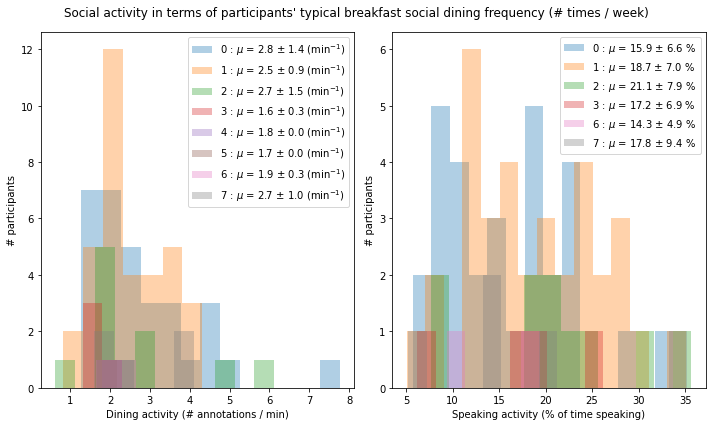

Lunch


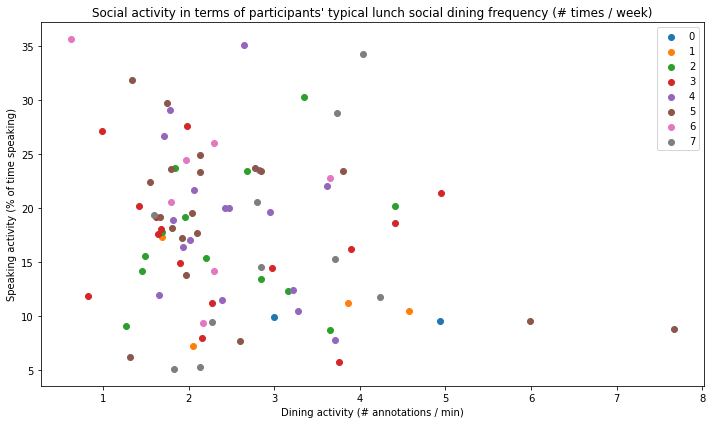

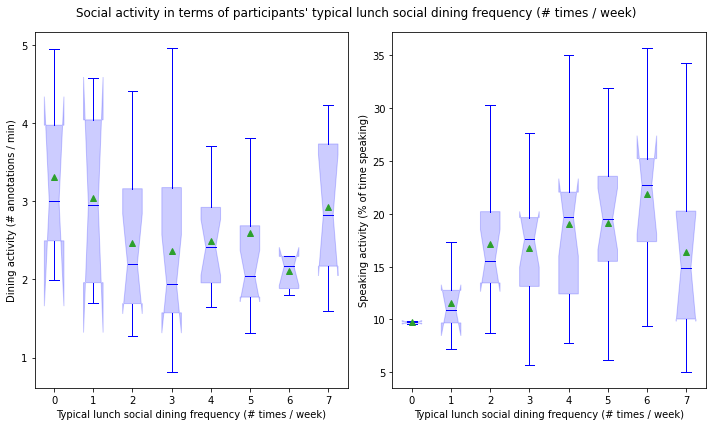

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


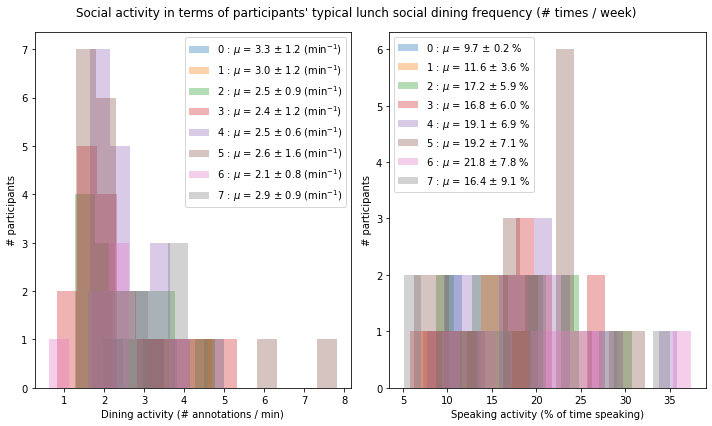

Dinner


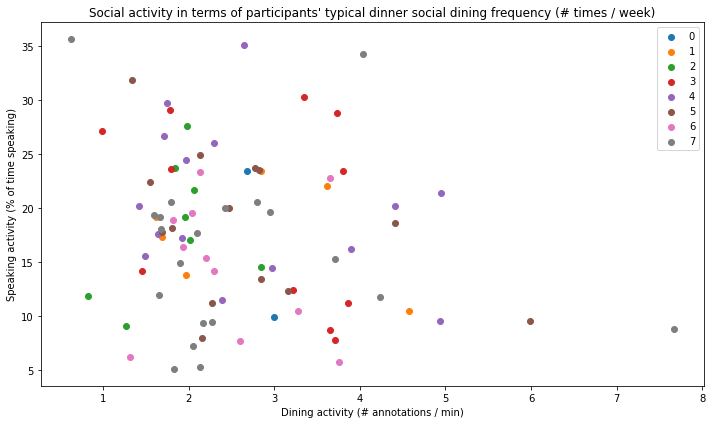

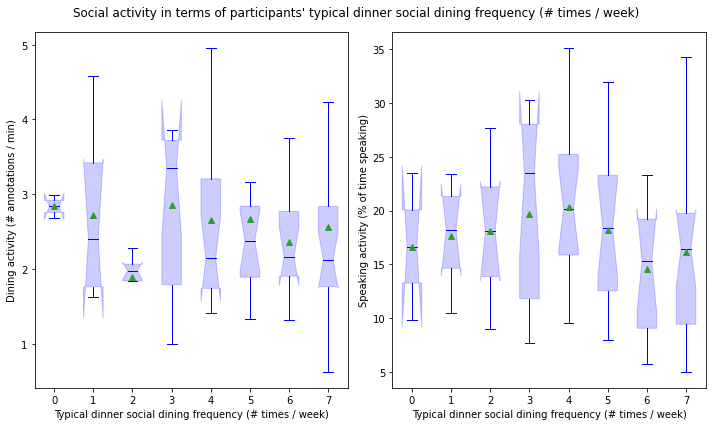

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


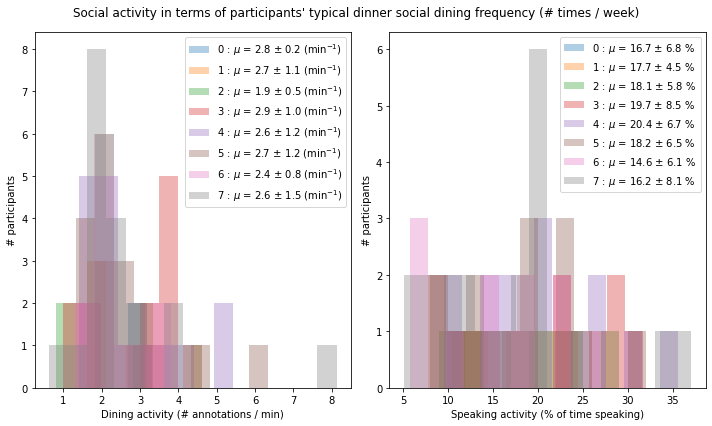

In [16]:
dining_freq_range = np.arange(8)
for i, meal_type in enumerate(['Breakfast', 'Lunch', 'Dinner']):
    print(meal_type)
    kwargs = dict(
        data = pd.to_numeric(pre_df[f'S2_{i + 1}']),
        categories = dining_freq_range,
        categories_label = f'Typical {meal_type.lower()} social dining frequency (# times / week)',
        fig_size=(10, 6)
    )
    plot_scatter(**kwargs)
    plot_boxplot(**kwargs)
    plot_hist(**kwargs)


#### 1.2.4.3 Typical dining location

Breakfast


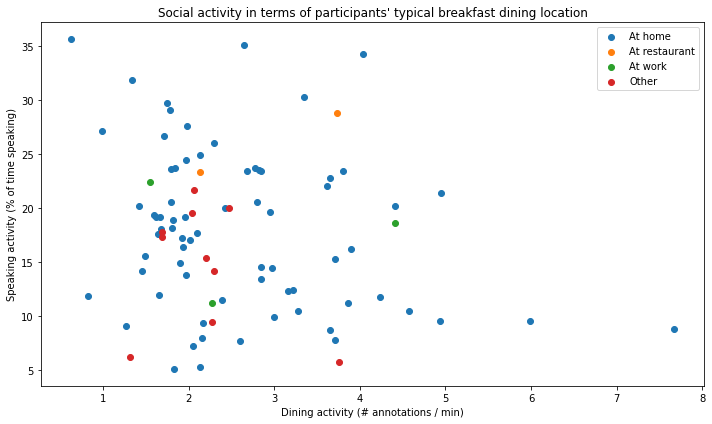

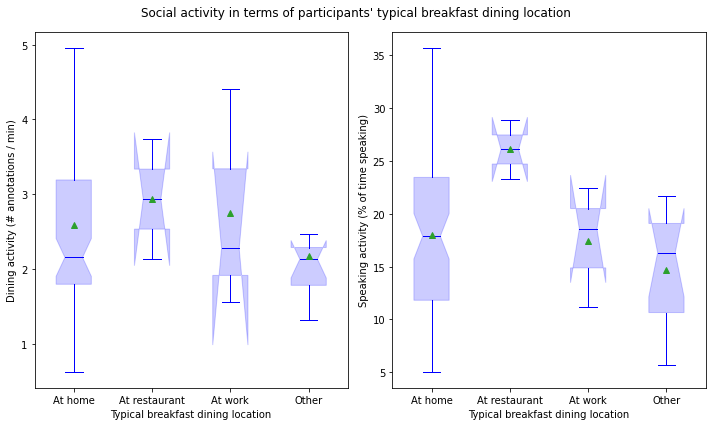

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


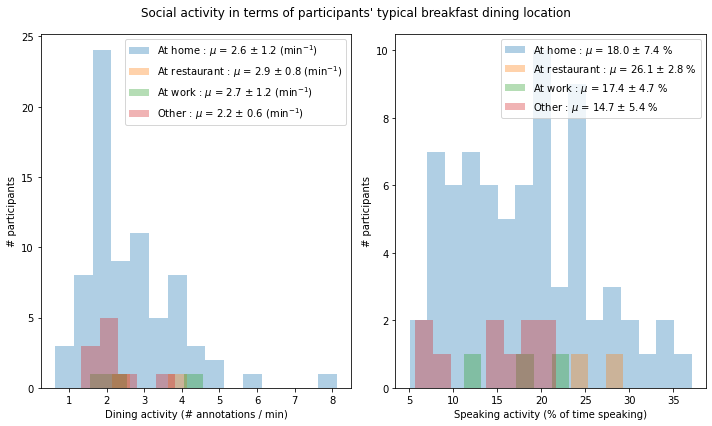

Lunch


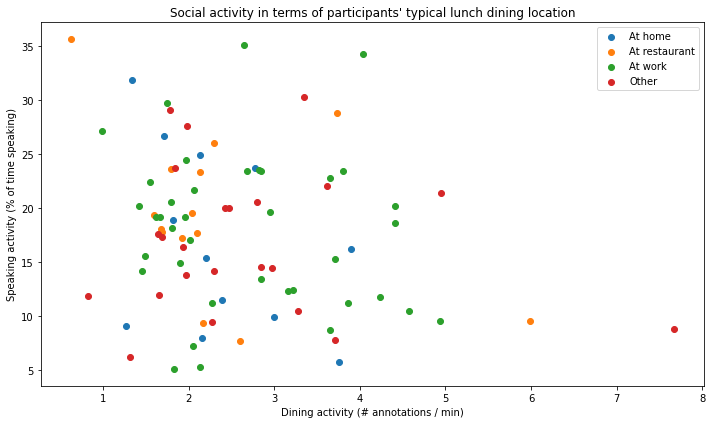

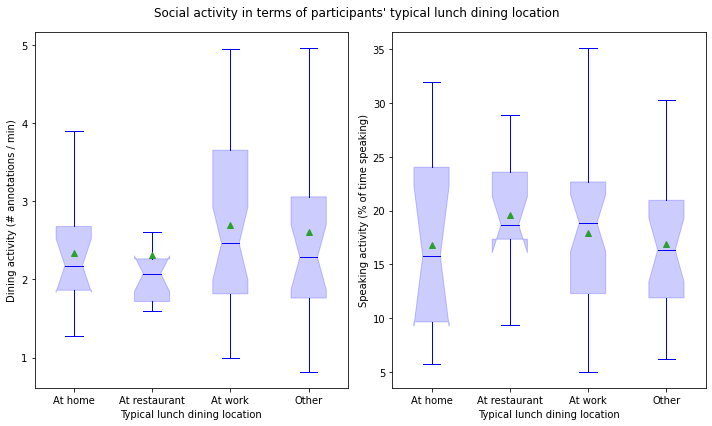

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


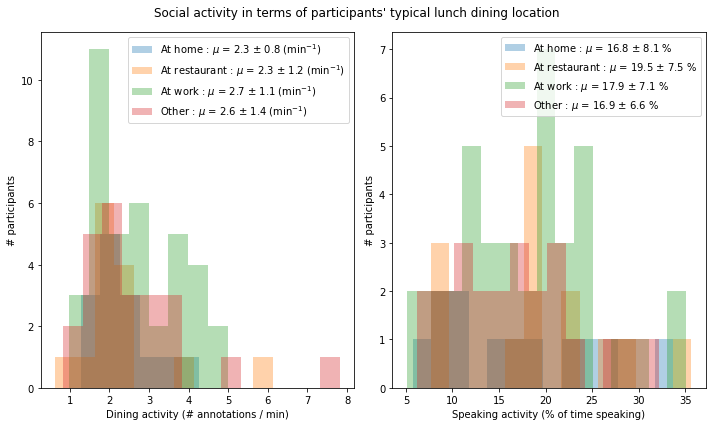

Dinner


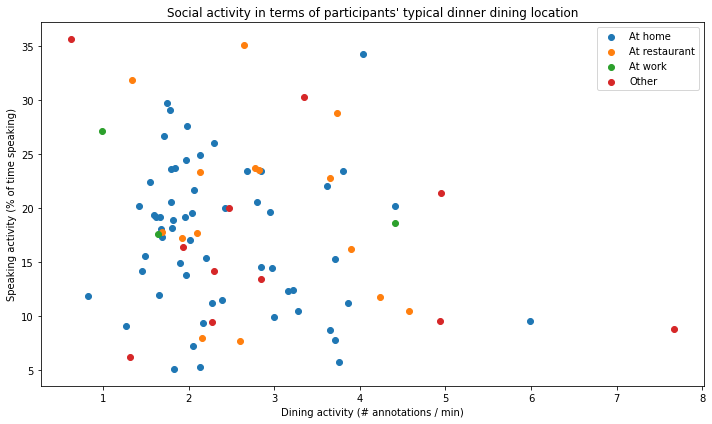

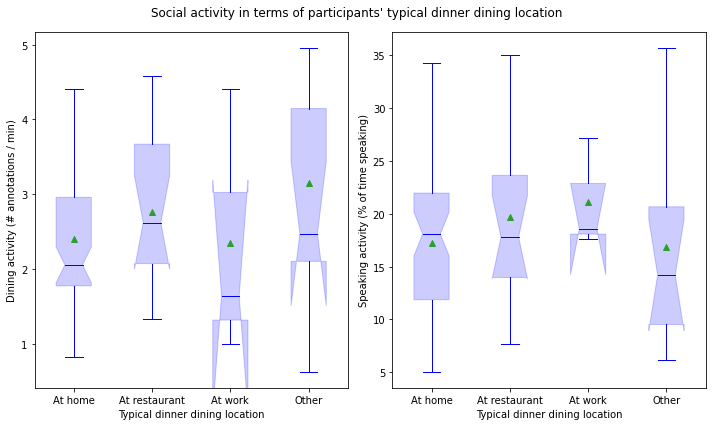

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


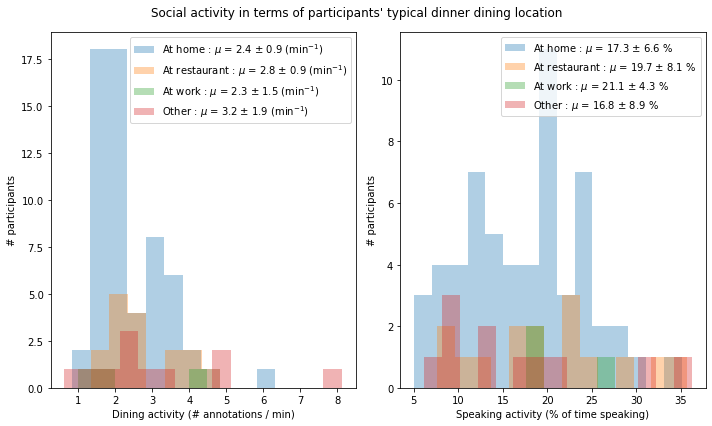

In [17]:
location_labels = {
    'At home': 'At home',
    'At restaurant': 'At restaurant',
    'At work': 'At work',
    'Other, please specify': 'Other'
}
for i, meal_type in enumerate(['Breakfast', 'Lunch', 'Dinner']):
    print(meal_type)
    kwargs = dict(
        data = np.array([ location_labels[label] for label in pre_df[f'S3_{i + 1}'] ]),
        categories = location_labels.values(),
        categories_label = f'Typical {meal_type.lower()} dining location',
        fig_size=(10, 6)
    )
    plot_scatter(**kwargs)
    plot_boxplot(**kwargs)
    plot_hist(**kwargs)


### 1.2.5 Dining experience ratings

My overall experience of the meal was great


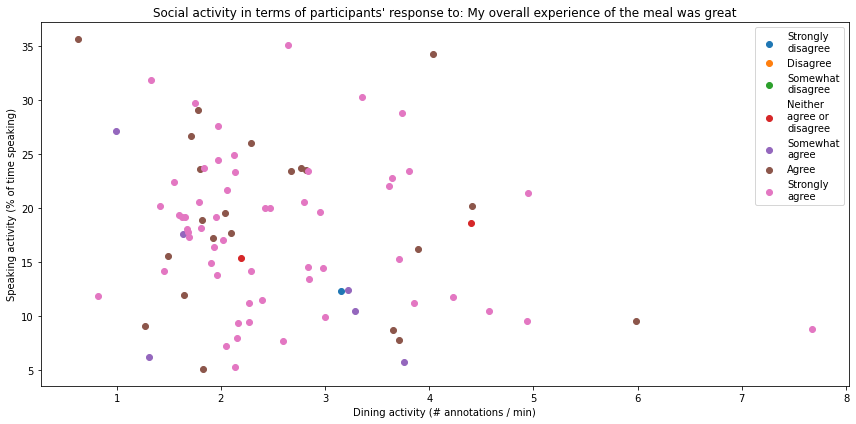

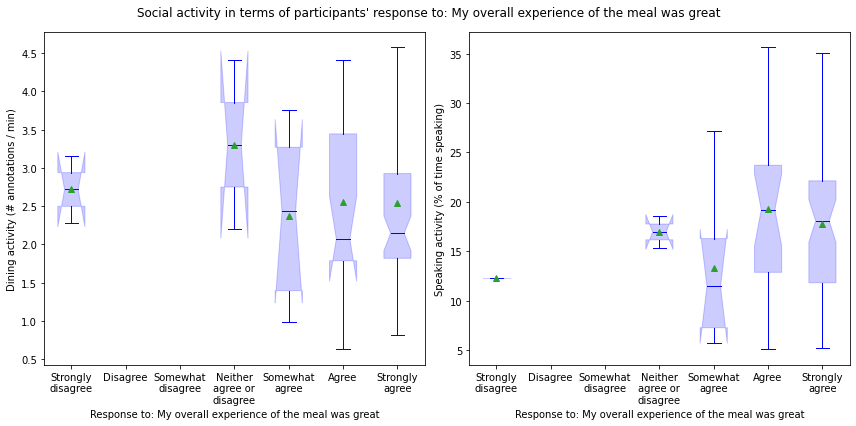

Bin width: 0.5 (min$^{-1}$)
	 No data for category Disagree
	 No data for category Somewhat
disagree
Bin width: 2 %
	 No data for category Disagree
	 No data for category Somewhat
disagree


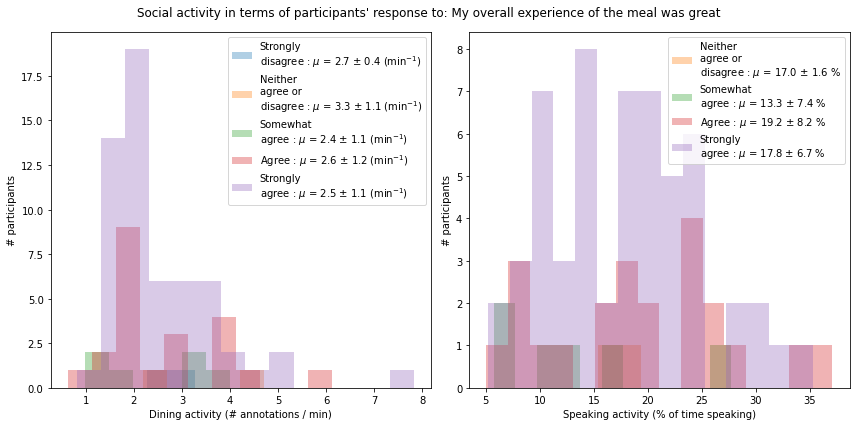

I liked the social interactions with the other participants very much


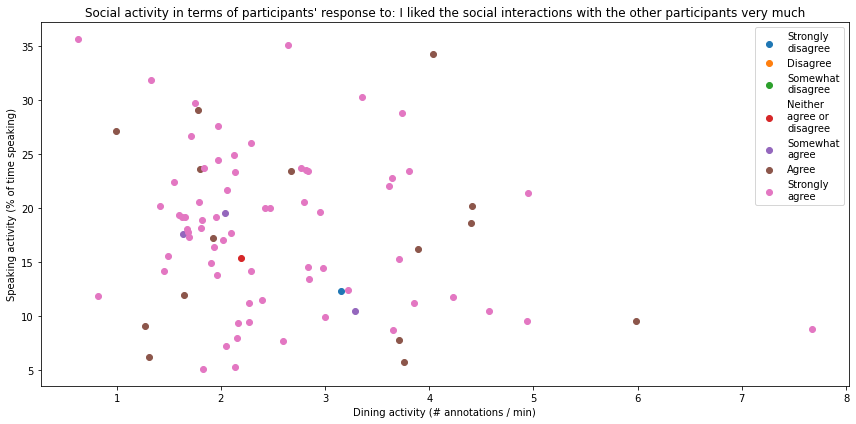

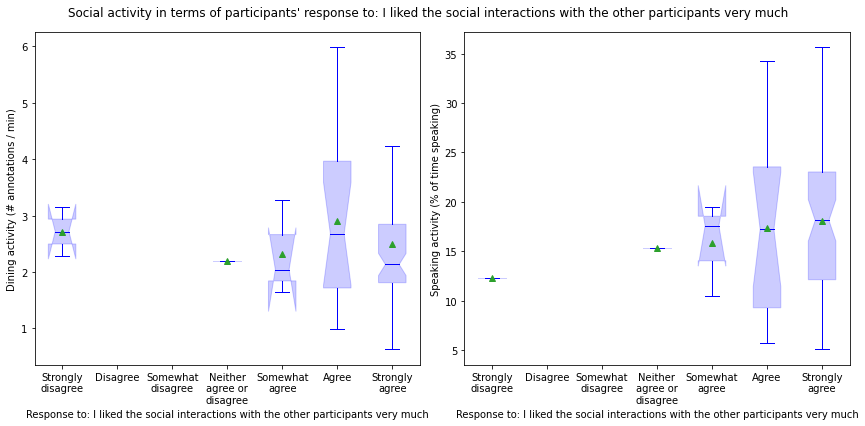

Bin width: 0.5 (min$^{-1}$)
	 No data for category Disagree
	 No data for category Somewhat
disagree
Bin width: 2 %
	 No data for category Disagree
	 No data for category Somewhat
disagree


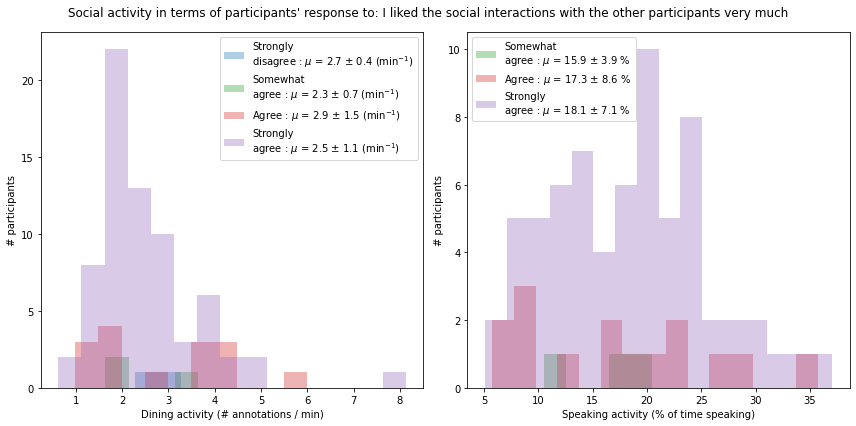

The food was excellent


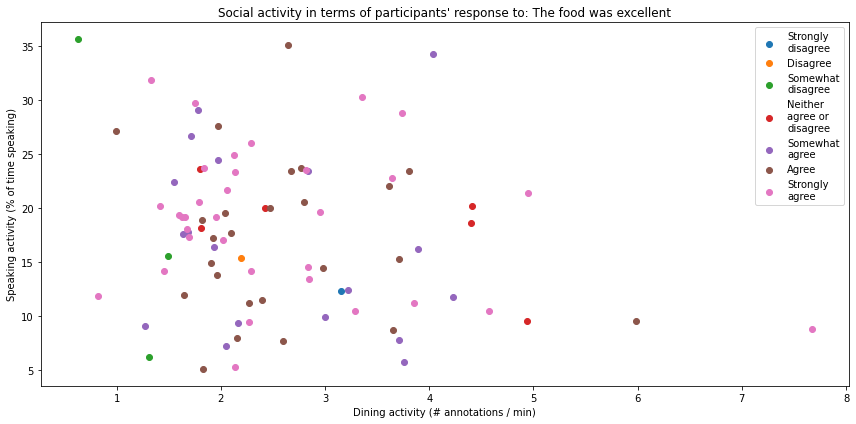

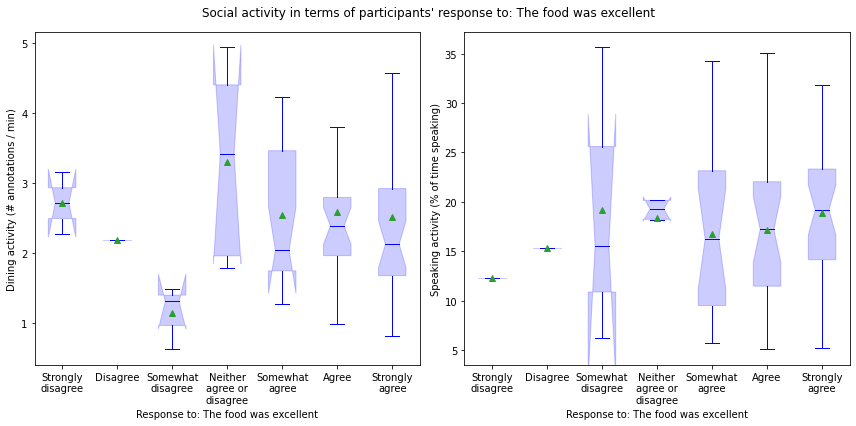

Bin width: 0.5 (min$^{-1}$)
Bin width: 2 %


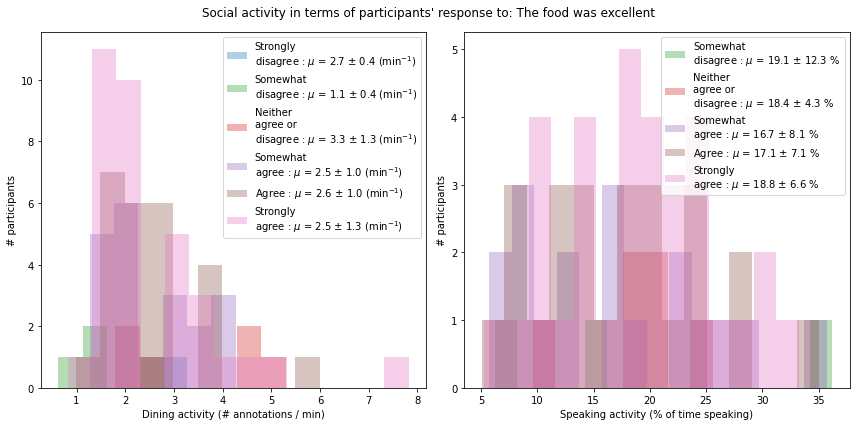

In [18]:
prompts = {
    'Q1_1': 'My overall experience of the meal was great',
    'Q1_2': 'I liked the social interactions with the other participants very much',
    'Q1_3': 'The food was excellent'
}
rating_labels = {
    '1  Strongly disagree': 'Strongly\ndisagree',
    '2  Disagree': 'Disagree',
    '3  Somewhat disagree': 'Somewhat\ndisagree',
    '4  Neither agree or disagree': 'Neither\nagree or\ndisagree',
    '5  Somewhat agree': 'Somewhat\nagree',
    '6  Agree': 'Agree',
    '7  Strongly agree': 'Strongly\nagree',
}
for prompt_key, prompt in prompts.items():
    print(prompt)
    kwargs = dict(
        data = np.array([ rating_labels[label] for label in post_df[prompt_key] ]),
        categories = rating_labels.values(),
        categories_label = f'Response to: {prompt}',
        fig_size=(12, 6)
    )
    plot_scatter(**kwargs)
    plot_boxplot(**kwargs)
    plot_hist(**kwargs)
